In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, PCA, LatentDirichletAllocation
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, silhouette_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

from xgboost import XGBClassifier
import scipy.stats as stats
import scipy.cluster.hierarchy as sch
from hmmlearn.hmm import GaussianHMM
import umap.umap_ as umap
import shap

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib.patches import Ellipse


print(os.getcwd())
# os.chdir('../')
# print(os.getcwd())

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/Python
/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1


In [2]:
df = pd.read_csv('wbl_05_22_super_sabbatical_processed.csv')


Summary descriptive statistics

In [ ]:
list(df.columns)

In [3]:
# Calculate the total number of participants
total_participants = df['playerId'].nunique()

# Calculate the total number of dyads (assuming dyads are represented by 'groupid')
total_dyads = df['groupId'].nunique()

# Calculate the gender breakdown
gender_counts = df['demographics_gender'].value_counts(normalize=True) * 100  # Percentage breakdown
male_percentage = gender_counts.get('male', 0.0)
female_percentage = gender_counts.get('female', 0.0)
unknown_percentage = gender_counts.get('', 0.0)

df['age'] = 2024 - df['demographics_birth_year']

# Calculate age statistics (mean and standard deviation)
mean_age = df['age'].mean()
std_age = df['age'].std()


print(f"Total participants: {total_participants}")
print(f"Total dyads: {total_dyads}")
print(f"Gender breakdown: {male_percentage:.1f}% male, {female_percentage:.1f}% female, {unknown_percentage:.1f}% unknown")
print(f"Mean age: {mean_age:.1f} years, SD: {std_age:.1f} years")

Total participants: 94
Total dyads: 47
Gender breakdown: 32.6% male, 67.4% female, 0.0% unknown
Mean age: 22.9 years, SD: 6.5 years


In [4]:
# For Agreement reached

subset = df[['groupId', 'deal_sheet_agreement_binary']]

group_counts = subset.groupby('groupId')['deal_sheet_agreement_binary'].value_counts().unstack(fill_value=0)

two_yes = group_counts[(group_counts['Yes'] == 2) & (group_counts['No'] == 0)].shape[0]
one_yes_one_no = group_counts[(group_counts['Yes'] == 1) & (group_counts['No'] == 1)].shape[0]
two_nos = group_counts[(group_counts['Yes'] == 0) & (group_counts['No'] == 2)].shape[0]

print(f"Number of groupIds with 2 YES: {two_yes}")
print(f"Number of groupIds with 1 YES and 1 NO: {one_yes_one_no}")
print(f"Number of groupIds with 2 NOs: {two_nos}")

Number of groupIds with 2 YES: 43
Number of groupIds with 1 YES and 1 NO: 1
Number of groupIds with 2 NOs: 2


In [5]:
# For Trip reached

subset = df[['groupId', 'deal_sheet_trip_binary']]


group_counts = subset.groupby('groupId')['deal_sheet_trip_binary'].value_counts().unstack(fill_value=0)


two_yes = group_counts[(group_counts['Yes'] == 2) & (group_counts['No'] == 0)].shape[0]
one_yes_one_no = group_counts[(group_counts['Yes'] == 1) & (group_counts['No'] == 1)].shape[0]
two_nos = group_counts[(group_counts['Yes'] == 0) & (group_counts['No'] == 2)].shape[0]


print(f"Number of groupIds with 2 YES: {two_yes}")
print(f"Number of groupIds with 1 YES and 1 NO: {one_yes_one_no}")
print(f"Number of groupIds with 2 NOs: {two_nos}")

Number of groupIds with 2 YES: 39
Number of groupIds with 1 YES and 1 NO: 5
Number of groupIds with 2 NOs: 2


In [6]:
# For Return Fund reached

subset = df[['groupId', 'deal_sheet_return_fund_binary']]


group_counts = subset.groupby('groupId')['deal_sheet_return_fund_binary'].value_counts().unstack(fill_value=0)


two_yes = group_counts[(group_counts['Yes'] == 2) & (group_counts['No'] == 0)].shape[0]
one_yes_one_no = group_counts[(group_counts['Yes'] == 1) & (group_counts['No'] == 1)].shape[0]
two_nos = group_counts[(group_counts['Yes'] == 0) & (group_counts['No'] == 2)].shape[0]


print(f"Number of groupIds with 2 YES: {two_yes}")
print(f"Number of groupIds with 1 YES and 1 NO: {one_yes_one_no}")
print(f"Number of groupIds with 2 NOs: {two_nos}")

Number of groupIds with 2 YES: 25
Number of groupIds with 1 YES and 1 NO: 14
Number of groupIds with 2 NOs: 7


Divide negotiations into quadrants

In [4]:
# Calculate Task Conflict and Relationship Conflict for each group
df['Task_Conflict'] = df[['post_negotiation_conflict_1', 'post_negotiation_conflict_2']].mean(axis=1)
df['Relationship_Conflict'] = df[['post_negotiation_conflict_3', 'post_negotiation_conflict_4']].mean(axis=1)
df['Conflict'] = df[['post_negotiation_conflict_1', 'post_negotiation_conflict_2','post_negotiation_conflict_3', 'post_negotiation_conflict_4']].mean(axis=1)
df['team_viability'] = df[['post_negotiation_viability_1', 'post_negotiation_viability_2']].mean(axis=1)

df = df[['groupId', 'Task_Conflict', 'Relationship_Conflict', 'Conflict', 'team_viability']]
df = df.groupby('groupId', as_index=False).mean()
 

In [7]:
# Compute means
mean_conflict = df['Conflict'].mean()
mean_viability = df['team_viability'].mean()

# classification function to classify negotiations using rules based aproach
def classify_negotiation(conflict, viability, mean_conf, mean_viab):
    if conflict < mean_conf and viability > mean_viab:
        return "Friendly Vibes"
    elif conflict >= mean_conf and viability > mean_viab:
        return "Functional"
    elif conflict < mean_conf and viability <= mean_viab:
        return "Apathetic"
    else:
        return "Dysfunctional"
    
# Apply classification
df["Negotiation_Category"] = df.apply(
    lambda row: classify_negotiation(row['Conflict'], row['team_viability'], mean_conflict, mean_viability), axis=1
)

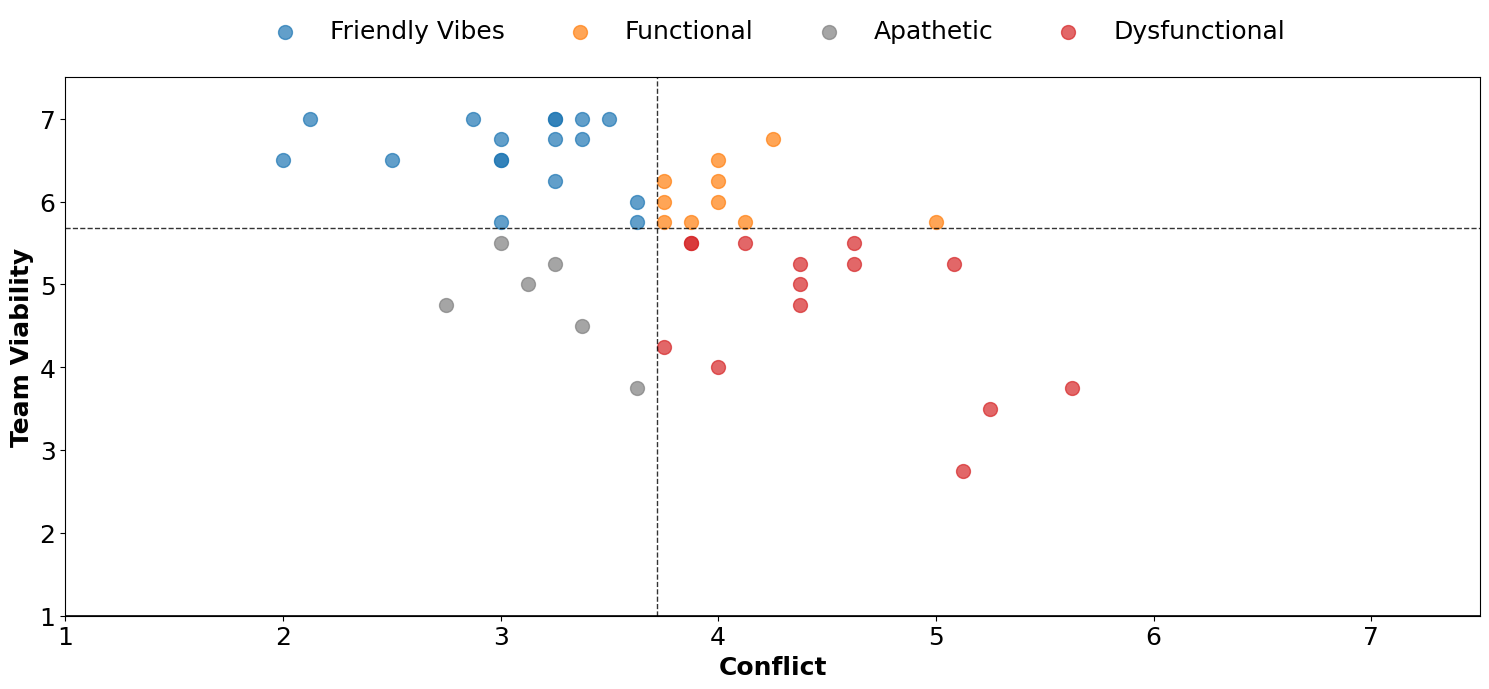

In [8]:
# Plot the classification

# Define colors for each category
category_colors = {
    "Friendly Vibes": "#1F77B4",  # Blue
    "Functional": "#FF7F0E",  # Orange
    "Apathetic": "#7F7F7F",  # Gray
    "Dysfunctional": "#D62728"  # Red
}

# Create the scatter plot
plt.figure(figsize=(15, 7))

# Plot data points with category colors
for category, color in category_colors.items():
    subset = df[df["Negotiation_Category"] == category]
    plt.scatter(subset['Conflict'], subset['team_viability'], label=category, color=color, alpha=0.7, s=100)

# Add decision boundaries (mean values)
plt.axvline(mean_conflict, color="black", linestyle="dashed", alpha=0.8, linewidth=1)
plt.axhline(mean_viability, color="black", linestyle="dashed", alpha=0.8, linewidth=1)

# Formatting plot aesthetics
plt.xlabel("Conflict", fontsize=18, fontweight="bold")
plt.ylabel("Team Viability", fontsize=18, fontweight="bold")


# Legend styling (placed at the top with extra spacing)
plt.legend(fontsize=18,
           loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=4, frameon=False)

# Ensure full axis range is visible
plt.xlim(1, 7.5)
plt.ylim(1, 7.5)

# Restore axis lines for a professional look
plt.axhline(y=plt.ylim()[0], color='black', linewidth=1.2)
plt.axvline(x=plt.xlim()[0], color='black', linewidth=1.2)

# Remove grid lines
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Show the plot
plt.tight_layout()
plt.show()


In [9]:
correlation, p_value = stats.pearsonr(df['Conflict'], df['team_viability'])

print(f"Pearson Correlation Coefficient: {correlation:.2f}")
print(f"P-Value: {p_value:.4f}")

Pearson Correlation Coefficient: -0.57
P-Value: 0.0000


**Load transcript data, merge and identify behaviours in each category**

In [10]:
df_features = pd.read_csv('./Output/super_May22/multimodal_data.csv')
df_features = df_features.dropna()
dvs = df.copy()

print(df_features.shape)
print(dvs.shape)

(4740, 230)
(47, 6)


In [11]:
# df_features = pd.read_csv('./Output/super_May22/multimodal_data.csv')
# dvs = df.copy()

# Extract the last 6 characters from PairID and groupId
df_features['MergeKey'] = df_features['PairID'].str[-6:]
dvs['MergeKey'] = dvs['groupId'].str[-6:]

dvs = dvs[['MergeKey', 'Negotiation_Category', 'Conflict', 'team_viability']]
# Perform a left join
merged_data = df_features.merge(dvs, on='MergeKey', how='left')

# Drop the temporary MergeKey column if not needed
merged_data.drop(columns=['MergeKey'])

merged_data.to_clipboard()

In [12]:
# Load the file
mmdata_LUT = pd.read_csv('./Output/super_May22/mmdata_LUT.csv')

# Clean up variable names in the 'variables' column of mmdata_LUT
mmdata_LUT['variable'] = mmdata_LUT['variable'].str.replace('_lexical_wordcount', '', regex=False)
mmdata_LUT['variable'] = mmdata_LUT['variable'].str.replace('_receptiveness_yeomans', '', regex=False)

# Clean up variable names in the columns of merged_data
merged_data.columns = merged_data.columns.str.replace('_lexical_wordcount', '', regex=False)
merged_data.columns = merged_data.columns.str.replace('_receptiveness_yeomans', '', regex=False)

# Display the cleaned data
# print(mmdata_LUT.head())
# print(merged_data.head())

In [13]:
mm_data = merged_data[['Pair_Speaker_turn',
 'PairID',
 'PersonID',
 'Speaker',
 'Speaker_original',
 'Turn',
 'Word',
 'StartTime',
 'EndTime',
 'Backchannel',
 'Overlap',
 'Contested',
 'Duration',
 'Negotiation_Category',
 'Conflict',
 'team_viability',
 'Sentiment',
 'word_count']]


In [14]:
# Get the list of columns to include from mmdata_LUT
columns_to_include = mmdata_LUT['variable'].tolist()

# Ensure the columns exist in merged_data before selecting them
columns_to_include = [col for col in columns_to_include if col in merged_data.columns]

# Extend mm_data with the selected columns
mm_data = mm_data.join(merged_data[columns_to_include])

In [ ]:
list(mm_data.columns)

Hierarchichal Dimensionality Reduction

In [15]:
# Identify Modality Groups
linguistic_vars = mmdata_LUT[mmdata_LUT['modality'] == 'Text']['variable'].tolist()
vocal_vars = mmdata_LUT[mmdata_LUT['modality'] == 'Vocal']['variable'].tolist()
facial_vars = mmdata_LUT[mmdata_LUT['modality'] == 'Facial']['variable'].tolist()

# Preprocessing
# Keep Linguistic Features Unchanged
linguistic_df = mm_data[linguistic_vars].copy()

# Function to aggregate highly correlated features
def aggregate_correlated_features(data, threshold=0.5):
    corr_matrix = data.corr()
    groups = []
    seen = set()
    mapping = {}
    
    for feature in data.columns:
        if feature not in seen:
            correlated = corr_matrix[feature][(corr_matrix[feature] > threshold) & (corr_matrix[feature] < 1.0)].index.tolist()
            if correlated:
                group = [feature] + correlated
                groups.append(group)
                seen.update(group)
            else:
                groups.append([feature])
                seen.add(feature)
    
    aggregated_data = pd.DataFrame()
    for group in groups:
        if len(group) > 1:  # Only create an aggregated feature if there are at least two original features
            common_prefix = group[0].split('_')[0]  # Extract common prefix from first feature
            group_name = f"Agg_{common_prefix}"
            aggregated_data[group_name] = data[group].mean(axis=1)
            mapping[group_name] = group  # Store mapping
        else:
            # Keep single features unchanged
            single_feature = group[0]
            aggregated_data[single_feature] = data[single_feature]
            mapping[single_feature] = [single_feature]
    
    return aggregated_data, mapping

# Aggregate Vocal and Facial Features Based on Correlation
scaler = MinMaxScaler()
mm_data[vocal_vars] = scaler.fit_transform(mm_data[vocal_vars])
mm_data[facial_vars] = scaler.fit_transform(mm_data[facial_vars])

vocal_df, vocal_mapping = aggregate_correlated_features(mm_data[vocal_vars])
facial_df, facial_mapping = aggregate_correlated_features(mm_data[facial_vars])

# Save the feature mapping to a CSV file for user review
mapping_df = pd.DataFrame({
    "New Feature Name": list(vocal_mapping.keys()) + list(facial_mapping.keys()),
    "Original Features": [", ".join(vocal_mapping[key]) for key in vocal_mapping] + [", ".join(facial_mapping[key]) for key in facial_mapping]
})

mapping_df.to_csv("feature_mapping_review.csv", index=False)
print("Feature mapping saved as feature_mapping.csv. Please review and update names before proceeding.")


Feature mapping saved as feature_mapping.csv. Please review and update names before proceeding.


In [16]:
# Step 1: Load the reviewed feature mapping
typed_feature_mapping = pd.read_csv("./Output/super_May22/feature_mapping_review.csv")

# Step 2: Extract lists of original vocal and facial features
original_vocal_facial_features = []
feature_groups = {}

for _, row in typed_feature_mapping.iterrows():
    new_feature_name = row["New Feature Name"]
    original_features_list = row["Original Features"].split(", ")  # Ensure list format
    original_vocal_facial_features.extend(original_features_list)
    feature_groups[new_feature_name] = original_features_list
    
# Step 3: Create a subset of df with only vocal and facial features
vocal_facial_df = mm_data[original_vocal_facial_features].copy()

# Step 4: Aggregate the variables based on mapping and keep only the new features
new_vocal_facial_df = pd.DataFrame()
for new_feature, original_features in feature_groups.items():
    new_vocal_facial_df[new_feature] = vocal_facial_df[original_features].mean(axis=1)
    
# Step 5: Remove all original vocal and facial features from df
updated_df = mm_data.drop(columns=original_vocal_facial_features)

# Step 6: Append the new variables to updated_df
updated_df = pd.concat([updated_df, new_vocal_facial_df], axis=1)

# Save the final dataset
final_csv_filename = "./Output/super_May22/mm_data_agg.csv"
updated_df.to_csv(final_csv_filename, index=False)
print(f"Final dataset saved as {final_csv_filename}. New feature names applied.")

Final dataset saved as ./Output/super_May22/mm_data_agg.csv. New feature names applied.


Analysis 1: Dyadic-level differences

Finding most prevalent groups of features by category, and by contested and uncontested periods

**Appendix**

In [13]:
# Group by groupID and calculate the average Task and Relationship Conflict for each group
group_conflicts = df.groupby('groupId')[['Task_Conflict', 'Relationship_Conflict']].mean().reset_index()

# Calculate the Pearson correlation
correlation, p_value = stats.pearsonr(group_conflicts['Task_Conflict'], group_conflicts['Relationship_Conflict'])

# Degrees of Freedom (n - 2, where n is the number of data points)
n = len(group_conflicts)  # Number of groups
degrees_of_freedom = n - 2

# Display the results
print(f"Pearson Correlation Coefficient: {correlation:.2f}")
print(f"P-Value: {p_value:.4f}")
print(f"Degrees of Freedom: {degrees_of_freedom}")

Pearson Correlation Coefficient: 0.31
P-Value: 0.0328
Degrees of Freedom: 45


In [14]:
constructive_disagreement = df.groupby('groupId')[['Conflict', 'team_viability']].mean().reset_index()

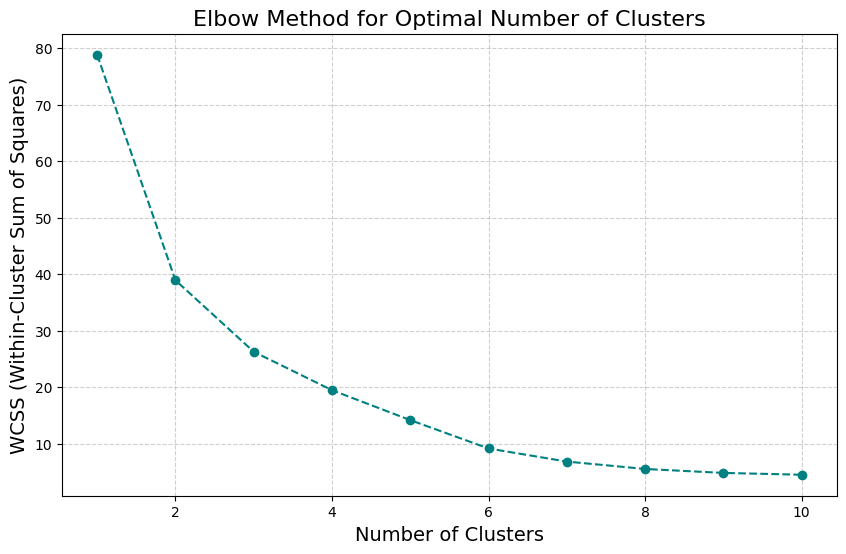

In [16]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []
max_clusters = 10  # Maximum number of clusters to test

for n_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    # kmeans.fit(group_conflicts[['Task_Conflict', 'Relationship_Conflict']])
    kmeans.fit(constructive_disagreement[['Conflict', 'team_viability']])
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--', color='teal')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=14)
plt.title('Elbow Method for Optimal Number of Clusters', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                       groupId  Conflict  team_viability  Cluster
0   01HYGGKFHG8BZ3KW7ZDR0KGC4N  5.125000            2.75        2
1   01HYGGM69HQN5GHTMDC1D1M24W  4.000000            6.25        3
2   01HYGGMT9R24HQ95866Y6BBDES  3.750000            6.00        3
3   01HYGGNS7A8Y691JXB24RMZ83G  5.000000            5.75        1
4   01HYGGNVDW9MXKDB9T4WG2GW8M  2.000000            6.50        0
5   01HYGGPM8PPG1XP0ZX8JQH9BHH  3.750000            4.25        1
6   01HYGGPVVFQ5KKAYPXSWBQ5GX2  3.125000            5.00        3
7   01HYGGQ7PWKMP8E7DR30SQ7YQ0  5.083333            5.25        1
8   01HYGGQDQ90NV6F5XQ253XWHK3  4.125000            5.75        3
9   01HYGGQDQCG0Q9FK0NAQDNHQXK  4.000000            4.00        1
10  01HYGGQH1YTD0YH3Q79X4HKEQH  4.625000            5.50        1
11  01HYGGR7XVC5XVR3XY0DSB0E3M  3.625000            6.00        3
12  01HYGGRCD1ZM7HBVX3Q43FV4W8  3.250000            6.25        0
13  01HYGGS1A78516RKJ4KPTX2V2G  4.250000            6.75        0
14  01HYGG

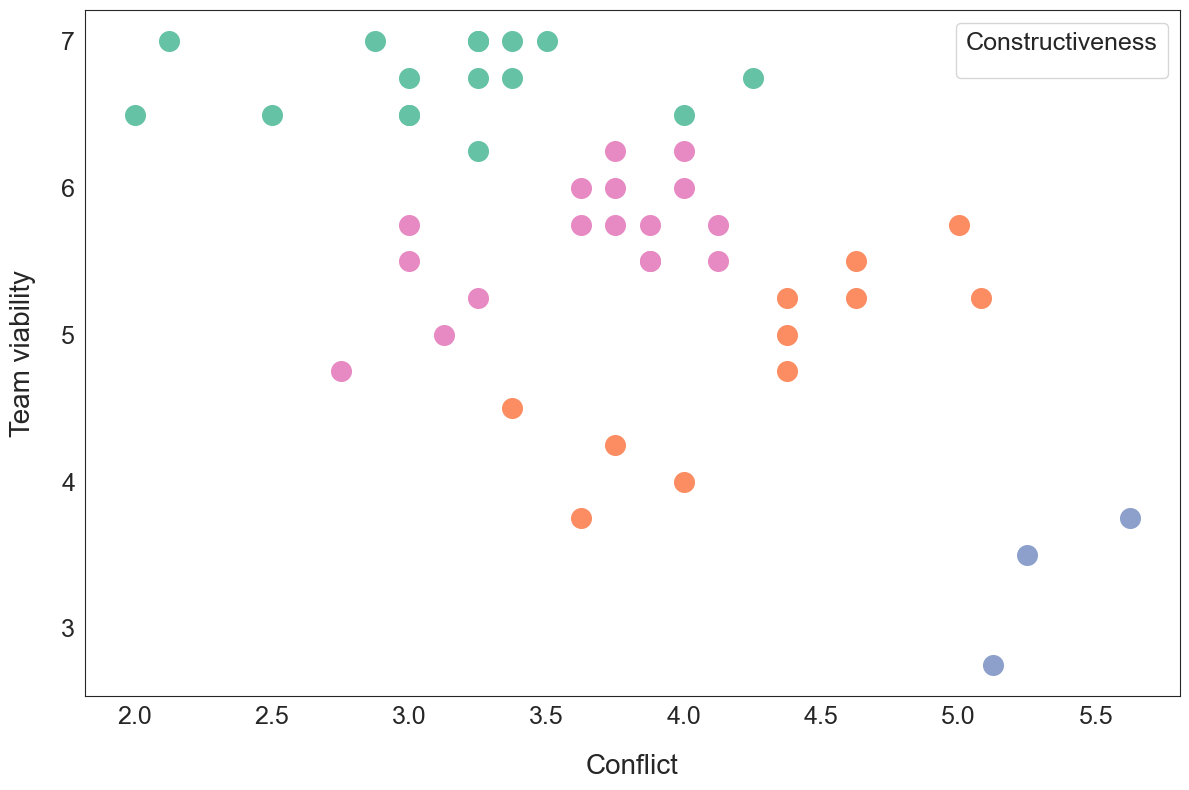

In [17]:
optimal_clusters = 4  # Update this based on the elbow point observed

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
constructive_disagreement['Cluster'] = kmeans.fit_predict(constructive_disagreement[['Conflict', 'team_viability']])


# Relabel the clusters
# group_conflicts['Cluster_Label'] = group_conflicts['Cluster'].replace({0: 'Low Conflict', 1: 'High Conflict', 2: 'Moderate Conflict'})

print(constructive_disagreement)
# Save the groups, cluster IDs, and average conflict scores to a CSV file
# output_file_path = './Output/super_May22/group_clusters.csv'
# group_conflicts.to_csv(output_file_path, index=False)

# Generate a mesh grid for shading the cluster areas
# x_min, x_max = constructive_disagreement['Conflict'].min() - 0.5, group_conflicts['team_viability'].max() + 0.5
# y_min, y_max = constructive_disagreement['team_viability'].min() - 0.5, group_conflicts['Conflict'].max() + 0.5
# xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict the cluster for each point in the mesh grid
# Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

# Plot the clustering results
plt.figure(figsize=(12, 8))
sns.set_style("white")  # Minimalist grid
palette = sns.color_palette("Set2", optimal_clusters)

# Plot the shaded cluster boundaries
# plt.contourf(xx, yy, Z, alpha=0.1, cmap=ListedColormap(palette))

# Scatter plot for each cluster
for cluster in range(optimal_clusters):
    cluster_data = constructive_disagreement[constructive_disagreement['Cluster'] == cluster]
    plt.scatter(
        cluster_data['Conflict'], 
        cluster_data['team_viability'], 
        s=200,  # Larger points
        # label=f"{cluster_data['Cluster_Label'].iloc[0]}", 
        color=palette[cluster], 
        # edgecolor='black', 
        # linewidth=0.5 
        alpha=1  # Slight transparency for elegance
    )
    

# Add cluster labels directly to areas
# cluster_centers = kmeans.cluster_centers_
# for i, (center_x, center_y) in enumerate(cluster_centers):
#     plt.text(
#         center_x, 
#         center_y, 
#         f"{group_conflicts['Cluster_Label'].unique()[i]}", 
#         fontsize=15, 
#         weight='bold', 
#         color='black', 
#         ha='center', 
#         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3')
#     )

# Add centroids
# centroids = kmeans.cluster_centers_
# plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='black', marker='X', edgecolor='white', linewidth=2)

# Axis labels and title
plt.xlabel('Conflict', fontsize=20, labelpad=18)
plt.ylabel('Team viability', fontsize=20, labelpad=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Legend (optional if cluster labels are inside areas)
plt.legend(fontsize=18, loc='upper right', frameon=True, title='Constructiveness', title_fontsize=18)

# Save and show the plot
plt.tight_layout()
plt.savefig('./Output/super_May22/clean_cluster_plot.png', dpi=300)
plt.show()

Segmenting conversations by conflict cluster

In [91]:
df_text = pd.read_csv('./Output/super_May22/Text_agg.csv')

In [104]:
# Extract the last 6 characters from PairID and groupId
df_text['MergeKey'] = df_text['PairID'].str[-6:]
group_conflicts['MergeKey'] = group_conflicts['groupId'].str[-6:]

# Perform a left join
merged_data = df_text.merge(group_conflicts, on='MergeKey', how='left')

# Drop the temporary MergeKey column if not needed
# merged_data.drop(columns=['MergeKey'], inplace=True)


cutoff_data = []
for convo_id, group in merged_data.groupby('PairID'):
    total_time = group['Start Time'].max()
    
    if total_time == 0:
        # If total_time is 0, default everything to "Opening"
        group['Stage'] = 0
    else:     
        # Assign stages based on cutoffs
        stage_labels = []
        for time in group['Start Time']:
            if time <= 0.25 * total_time:
                stage_labels.append(0)
            elif time <= 0.50 * total_time:
                stage_labels.append(1)
            elif time <= 0.75 * total_time:
                stage_labels.append(2)
            else:
                stage_labels.append(3)
        
        group['Stage'] = stage_labels
    
    # Store results
    cutoff_data.append(group)

# Combine results
merged_data = pd.concat(cutoff_data, ignore_index=True)

merged_data.to_clipboard()

In [107]:
summary = (
    merged_data.groupby(['Cluster_Label', 'Stage'])
    .agg(
        avg_turns=('Turn', lambda x: x.groupby(merged_data.loc[x.index, 'PairID']).count().mean()),
        std_turns=('Turn', lambda x: x.groupby(merged_data.loc[x.index, 'PairID']).count().std(ddof=1)),
        se_turns=('Turn', lambda x: x.groupby(merged_data.loc[x.index, 'PairID']).count().std(ddof=1) / 
                 np.sqrt(x.groupby(merged_data.loc[x.index, 'PairID']).count().count())),
        avg_wordcount=('word_count', 'mean'),
        std_wordcount=('word_count', 'std'),
        n_wordcount=('word_count', 'count'),
        avg_sentiment=('Sentiment', 'mean'),
        std_sentiment=('Sentiment', 'std'),
        n_sentiment=('Sentiment', 'count'),
        avg_contested=('Contested', 'mean'),
        std_contested=('Contested', 'std'),
        n_contested=('Contested', 'count'),
        typical_start_time=('Start Time', 'mean'),
        typical_end_time=('End Time', 'mean')
    )
    .reset_index()
)

summary['avg_duration'] = summary['typical_end_time'] - summary['typical_start_time']

summary['se_wordcount'] = summary['std_wordcount'] / np.sqrt(summary['n_wordcount'])
summary['se_sentiment'] = summary['std_sentiment'] / np.sqrt(summary['n_sentiment'])
summary['se_contested'] = summary['std_contested'] / np.sqrt(summary['n_contested'])


summary = summary.melt(id_vars= ['Cluster_Label', 'Stage'])
summary = summary.pivot(index = ['Cluster_Label', 'variable'],columns='Stage')
print(summary)

# Save the summary
merged_data.to_csv("./Output/super_May22/Segmented_Conversations_With_Conflicts.csv")
summary.to_csv("./Output/super_May22/Conflict_Group_Stage_Summary.csv")

                                       value                          \
Stage                                      0           1           2   
Cluster_Label variable                                                 
High Conflict avg_contested         0.260492    0.310524    0.342026   
              avg_duration         11.370304   14.467681   13.800271   
              avg_sentiment         0.122338    0.095563    0.108055   
              avg_turns            27.520000   22.880000   23.440000   
              avg_wordcount        24.572674   30.755245   26.861775   
              n_contested         688.000000  572.000000  586.000000   
              n_sentiment         688.000000  572.000000  586.000000   
              n_wordcount         688.000000  572.000000  586.000000   
              se_contested          0.016580    0.019245    0.019467   
              se_sentiment          0.008920    0.009186    0.009004   
              se_turns              2.976642    2.591216    3.20

In [103]:
file_path = "./Output/super_May22/Conflict_Group_Stage_Summary.csv"
summary = pd.read_csv(file_path, skiprows=2)

/var/folders/pz/gk2tz1l92yd7r5jl_7s8l8d00000gp/T/ipykernel_11267/3507282805.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


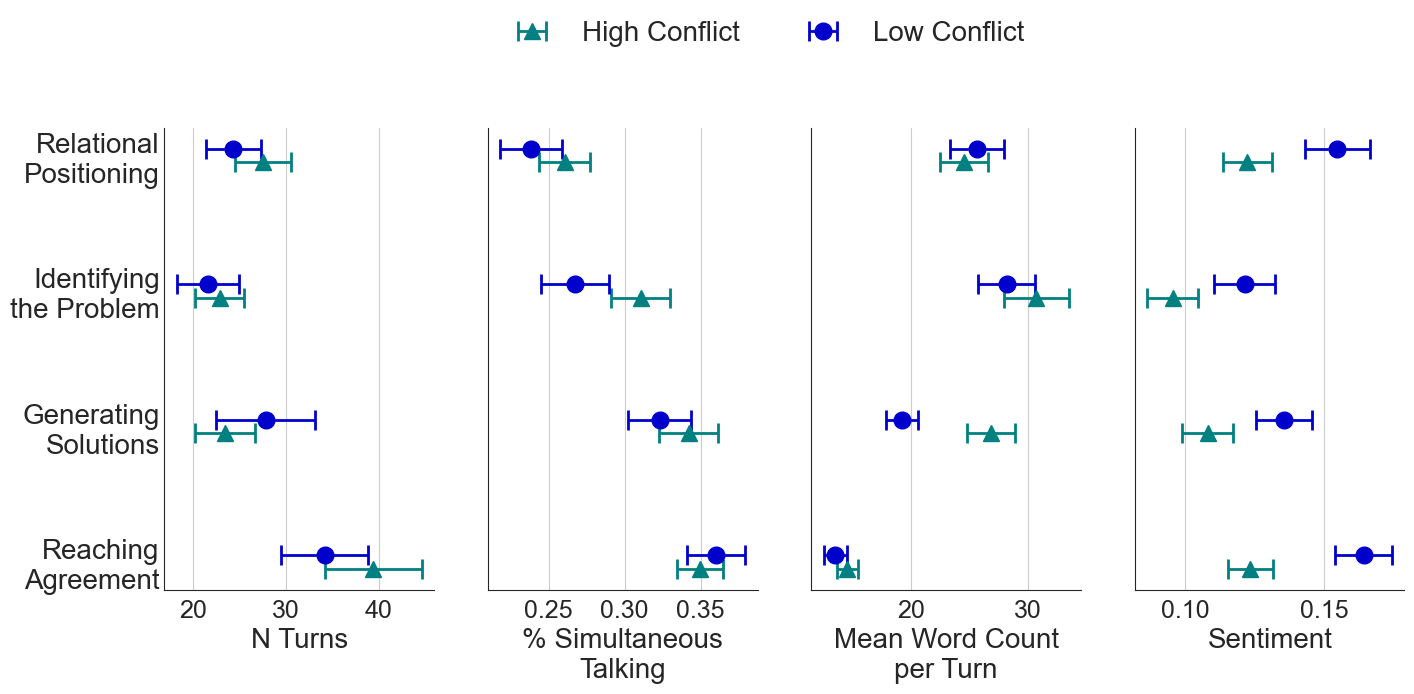

In [108]:
# Load the CSV file
file_path = "./Output/super_May22/Conflict_Group_Stage_Summary.csv"
summary = pd.read_csv(file_path, skiprows=2)

# Rename columns appropriately
summary.rename(columns={'Unnamed: 0': 'Cluster_Label', 'variable': 'Variable', 
                        'Unnamed: 2': 0, 'Unnamed: 3': 1, 'Unnamed: 4': 2, 'Unnamed: 5': 3}, inplace=True)

# Melt the DataFrame to long format for easier plotting
summary = summary.melt(id_vars=['Cluster_Label', 'Variable'], var_name='Stage', value_name='Value')

# Convert 'Stage' column to numeric
summary['Stage'] = summary['Stage'].astype(int)

# Extract standard errors rows
se_summary = summary[summary['Variable'].str.startswith('se_')].copy()
se_summary['Variable'] = se_summary['Variable'].str.replace('se_', 'avg_')

# Merge standard errors back into the main dataframe
summary = summary.merge(se_summary, on=['Cluster_Label', 'Variable', 'Stage'], suffixes=('', '_se'))

# Correct the stage order so that the labels match the data points
stage_order = {0: 3, 1: 2, 2: 1, 3: 0}
summary["Stage"] = summary["Stage"].map(stage_order)

# Define formatted stage labels with multi-line formatting
formatted_stage_labels = {
    0: "Reaching\nAgreement",
    1: "Generating\nSolutions",
    2: "Identifying\nthe Problem",
    3: "Relational\nPositioning"
}

# Define cluster names, colors, and marker styles
cluster_names = {"Low Conflict": "Low Conflict", "High Conflict": "High Conflict"}
colors = {"Low Conflict": "#0000cd", "High Conflict": "#008080"}
markers = {"Low Conflict": "o", "High Conflict": "^"}
offset = .05  
larger_marker_size = 12  

# Define metric order and labels with multi-line formatting
ordered_metrics = ["avg_turns", "avg_contested", "avg_wordcount", "avg_sentiment"]
ordered_se_metrics = ["se_turns", "se_contested", "se_wordcount", "se_sentiment"]
metric_labels = {
    "avg_turns": "N Turns",
    "avg_contested": "% Simultaneous\nTalking",
    "avg_wordcount": "Mean Word Count\nper Turn",
    "avg_sentiment": "Sentiment"
}


# Create the figure
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True, gridspec_kw={'wspace': 0.2})

for i, (metric, std_metric) in enumerate(zip(ordered_metrics, ordered_se_metrics)):
    ax = axes[i]
    subset = summary[summary['Variable'] == metric]
    
    for cluster in subset['Cluster_Label'].unique():
        cluster_name = cluster_names[cluster]  # Rename clusters
        cluster_subset = subset[subset['Cluster_Label'] == cluster]
        ax.errorbar(
            cluster_subset['Value'],
            cluster_subset['Stage'] - (offset if cluster_name == "High Conflict" else -offset),  
            xerr=cluster_subset['Value_se'],
            fmt=markers[cluster_name],  # Use different marker styles
            color=colors[cluster_name],
            markersize=larger_marker_size,  # Larger markers
            label=cluster_name if i == 0 else "",
            capsize=7,  # Larger caps for error bars
            capthick=2,  # Thicker error bar caps
            elinewidth=2  # Increase error bar line thickness
        )

    ax.set_xlabel(metric_labels[metric], fontsize=20)
    ax.tick_params(axis='x', labelsize=18)  # Keep x-axis ticks
    ax.tick_params(axis='y', length=0)  # Remove only the y-axis tick marks
    ax.set_yticks(list(formatted_stage_labels.keys()))
    ax.set_yticklabels([formatted_stage_labels[stage] for stage in formatted_stage_labels], fontsize=20)
    
    
    # Remove all horizontal grid lines and keep only vertical grid lines
    ax.grid(False)  # Remove all grid lines first
    ax.grid(axis='x', color='grey', alpha=0.4)  # Add only vertical lines

    # Remove top and right borders of each subplot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Remove y-axis title
axes[0].set_ylabel("")

# Move legend to a more central position
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, fontsize=20, frameon=False)

# Improve layout
plt.tight_layout()
plt.show()